# Time Series Analysis and Prediction with ARIMA

Here we will produce reliable forecasts of time series by taking into account concepts like 
autocorrelation, seasonality, stationarity, etc and time series forecasting method : ARIMA

ARIMA(p,d,q)

In [1]:
# Importing libraries : 

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # This tries to replicate the styles from "FiveThirtyEight.com"

In [2]:
# Dataset

data = sm.datasets.co2.load_pandas()
y = data.data

Here, the data will be preprocessed. Weekly data can be tricky to work with, since it's a brief amount of time, so here we'll use the resample function. For simplicity, we can also use fillna() function to ensure that we have no missing values. 

If you don't drop/ omit the missing values, the the following are additional ways to fill up missing data : 

1: Non time series specific method: 
    - Mean , median, mode
2: Time series specific methods: 
    - Last observation carried forward (LOCF)
    - Next observation carried backward (NOCB)
    - Linear interpolation
    - Spline Interpolation: This relies on the assumption that adjacent observations are similar 
    to one another. These methods don't work well when it is not valid, that is there is strong
    seasonality present.
3: Combination of seasnal adjustment and then other methods: 
    - Here first the data is deseasonalized, then interpolation/ random/ mean, etc is used. After
    filling up the missing values, the data is reseasonalized. 
    NB: There are 2 main ways to deseasonalize the data : 
        a. Multiplicative seasonal adjustment
        b. Additive seasonal adjustment

In [3]:
# The 'MS' string groups the data in buckets by the start of the month

y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in the missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


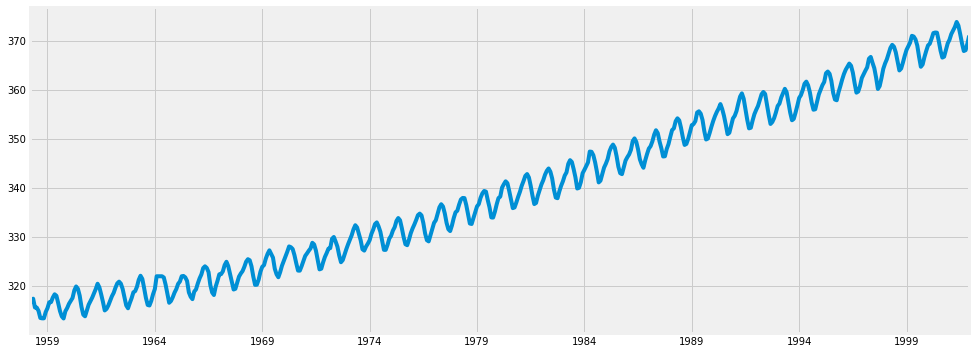

In [4]:
# Drawing a line plot to visualize the data : 
y.plot(figsize=(15,6))
plt.show()

Here from the plotted line graph it is apparent that there is seasonality in the data along with an overall increasing trend. Now that we've preprocessed and explored the data, let's move on to time series forecasting with ARIMA

---

### Building the time series forecasting model

There are 3 distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted as ARIMA(p, d, q). These 3 parameters account for seasonality, trend and noise in the datasets : 
    
    - p is auto-regressive part of the model which allows to incorporate past values into the 
      model. It is similar to stating that today would be warm since the past 3 days have been 
      warm
    
    - d is the integrated part of the model. This includes terms in the model that incorporate the
      amount of differencing (number of past time points to subtract from the current value) to 
      applyto the time series. Ex : it is likely to be the same temperature tomorrow if the 
      temperature has witnessed very less difference in the last 3 days.
    
    - q is the moving average part of the model. This allows us to set the error of the model as a 
      linear combination of error values observed at a previous time point

### Parameter selection : 

When looking to fit the time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA (p, d, q)(P, D, Q)s that optimize the metric of interest. The parametrization of ARIMA is a painstaking manual process that requires domain knowledge and time. R provides automatic statistical tool to address this issue but it hasn't been imported to python yet. 

Here, we'll use Grid Search to iteratively explore different combination of parameters. For each combination of parameters, we fit a seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once the entire landscape of parameters has been explored, the parameters that yield the best results would be selected. 

### Notes : 
#### Q1 : What can be the values assigned to p,d,q?

A  : Lots of different whole numbers can be tested to find the best values. But the numbers need to 
     be whole numbers.

#### Q2 : What are other methods to find the values of p,d,q?

A  : 
     1. Look at the autocorrelation graph of the data (will help if moving average model is 
        correct)
     2. Look at partial autocorrelation graph (will help if autoregressive model is appropriate)
     3. Look at the extended correlation chart of the data (will help if a combination of AR and 
        MA are needed.
     4. Akaike's Informaion Criterion (AIC) on a set of models and investigate the models with the 
        lowest AIC values.
     5. try the Schwartz Bayesian Criterion (BIC) and investigate the models with lowest BIC
        values

In [11]:
# Defining the p, d, q parameters in the range (0,2) : 
p = d = q = range(0, 2)

# Generating all different combinations of p, d, q triplets : 
pdq = list(itertools.product(p, d, q))

# Generating all different combinations of p, d, q triplets : 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


---
Now we can use the combinations of the p, d, q values obtained to evaluate our ARIMA model. This processs is known as grid search (or hyperparameter optimization) for model selection.

To evaluate the performance of model using different parameters, we will use AIC (Akaike Information Criterion) which is conveniently returned with ARIMA models fitted with statsmodels. The AIC measures how well the model fits the data while taking into account the overall complexity of the model. 

#### Important : A model that fits the data very well using lots of features will have a larger AIC score than a model that fits the data very well using less features. Hence we will pick lower AIC score here. 

In the following lines of code, we use the SARIMAX() function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order specifies the (P, D, Q, S) seasonal component od Seasonal ARIMA model. After fitting each SARIMAX() model, the code prints out its respective AIC scores. 

In [15]:
warnings.filterwarnings("ignore") # specified to ignore warning messages

for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try: 
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036742
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727636197
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287840438874
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912934656
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755206244
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327721806
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066918753
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716848045
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1089.8231627047912
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:865.7138827229446
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893632262
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987990464
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194085


Note : As some parameter contributions may lead to numerical misspecifications, we explicitly suppress the warning messages.

#### Using grid search we identified the set of parameters (SARIMAX(1 , 1,  1) x (1, 1, 1, 1, 12) that produces the best fitting model to our time series data by giving the lowest AIC. Using that data with SARIMAX() model : 

In [21]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (1, 1, 1),
                                seasonal_order = (1, 1, 1, 12),
                                enforce_stationality = False,
                                enforce_invertibility = False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3985      0.086      4.647      0.000       0.230       0.567
ma.L1         -0.6996      0.070    -10.046      0.000      -0.836      -0.563
ar.S.L12       0.0196      0.053      0.369      0.712      -0.084       0.123
ma.S.L12      -0.8751      0.032    -27.652      0.000      -0.937      -0.813
sigma2         0.1080      0.005     21.675      0.000       0.098       0.118


Note : The summary returns a significant amount of data from which we can look at the coefficients alone by using the tables[1]. 

plot_diagnostics object allows us to quickly generate model diagnostics and investigate for unusual behavior

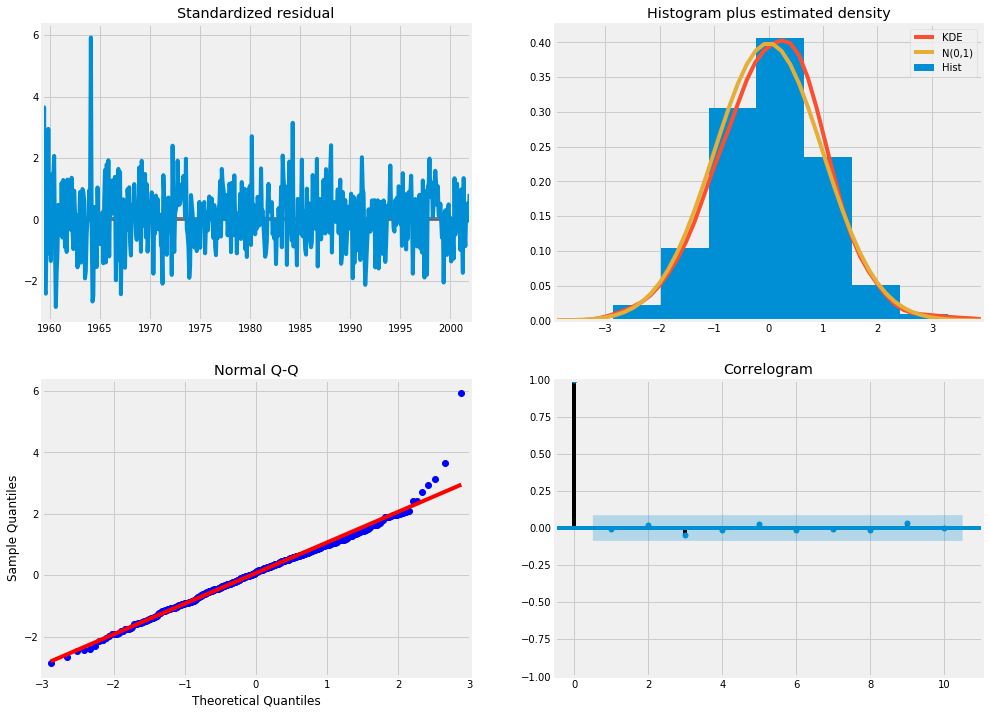

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Here from the plot_diagnostics we have to ensure that our model is uncorrelated and normally distributed with zero mean. We observed those in the following ways: 
1. In the histogram plot the red KDE line closely follows the line with N(0,1)
2. The Q-Q plot shows ordered distribution of residuals (blue dots) follows the linear trend of samples taken from a standard normal distribution with N(0,1). This is a strong indication that the residuals are normally distributed
3. The standardized residual plot don't show any obvious seasonality and appear like white noise. This is confirmed by autocorrelation as potrayed by the correlogram

All these lead to the conclusion that the model produces satisfactory results.

We might arrive at even better results if we widen the grid search

### Validating Forecasts

Now checking how well our predicted values match real values from the validation set: 

In [23]:
pred = results.get_prediction(start = pd.to_datetime('1998-01-01'), dynamic = False)
pred_ci = pred.conf_int() # confidence interval

The dynamic = False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using full history upto that point.

We can now plot the real and predicted values of the CO2 time series to see how our model performs.

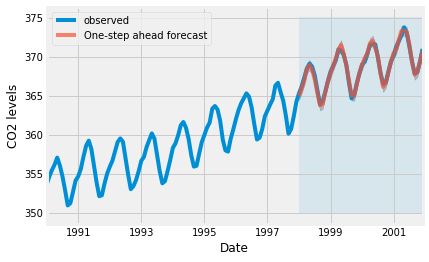

In [35]:
ax = y['1990':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead forecast', alpha = 0.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 levels')
plt.legend()
plt.show()

Validating the models by calculating the MSE : 

In [38]:
# Extracting the predicted and actual values : 
y_predicted = pred.predicted_mean
y_actual = y['1998-01-01':]

# Computing the MSE : 
mse = ((y_predicted - y_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


Note : An MSE of 0 means the prediction model is totally accurate (ideal). But in real case scenarios 0.8 is pretty good

### Final predictions and Visualization : 

We can use get_forecast() to get predictions of the time series : 

In [39]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

From the predictions obtained we can plot the mean and confidence interval and combine it with the time series data we have from before :  : 

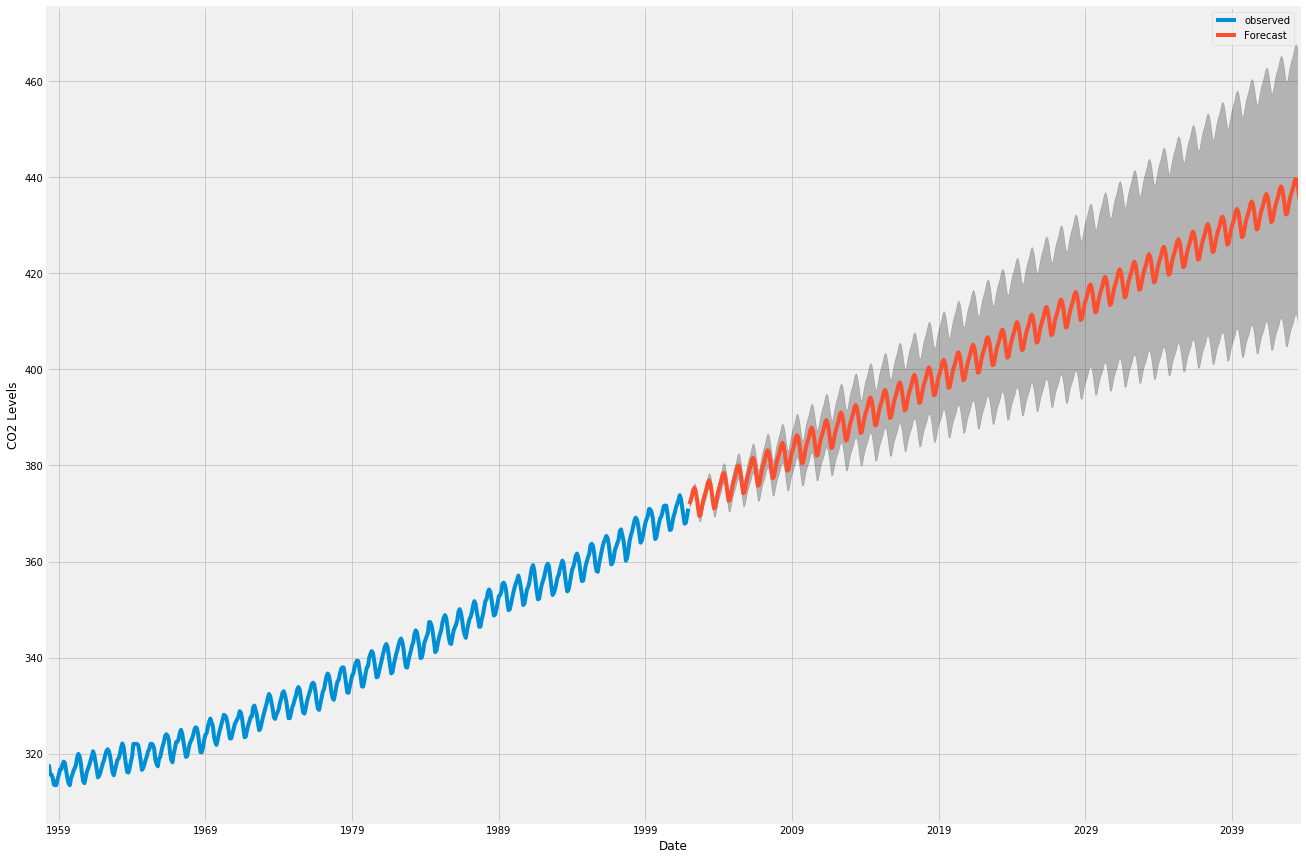

In [40]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Both the forecast and assosciated confidence level can be used to further understand the time series and figure out what to expect. 